# Milestone 2 Phase 2
Fathiyah Kalamal Haq - Batch 009

# **Clickbait News Detector**

Clickbait news are usually use when someone want to gain profit or up their account or a name of articles based on sensational headlines. People tends to click a news based on headline interest. Therefore, clickbait is used to attract reader's attention. The headlines has to make reader curious about what inside. Everytime they click the website, the website became more popular. There's some advantages and disadvantages by using clickbait. 

Advantages:
- can upvote the websites so they get more viewers/readers and then get popularity.

Disadvantages:
- negative reaction
- reader's disappointment, especially if the headline and the news is not relevant
- misleading information

Especially when the clickbait is about something sensitive like president campaign, racist news,etc. It is very useful if we can classify whether the news is a clickbait or not. To classify if a news is clickbait or not, Deep Neural Network model can predict this case study. 

I compare RNN and NN model to predict and choose the best architecture for news classification. The dataset source is from [kaggle](https://www.kaggle.com/datasets/amananandrai/clickbait-dataset) that consist of 2 columns (headline and clickbait). The clickbait column is binary where 1 is clickbait and 0 is normal news. The clickbait news  are collected from sites such as ‘BuzzFeed’, ‘Upworthy’, ‘ViralNova’, ‘Thatscoop’, ‘Scoopwhoop’ and ‘ViralStories’.
The relevant or non-clickbait headlines are collected from many trustworthy news sites such as ‘WikiNews’, ’New York Times’, ‘The Guardian’, and ‘The Hindu’.

You can detect clickbait news in the apps I build [here](https://click-detect-fath.herokuapp.com/) 

# Import Libraries

In [280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# EDA
from nltk.corpus import stopwords
import string
#preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from tensorflow.data import Dataset
from tensorflow.keras.layers import Embedding
# model 
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling1D, LSTM, GRU, Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping
# metrics
from sklearn.metrics import classification_report
from tensorflow.keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

# Data Loading

First, let's load the dataset...

In [94]:
df = pd.read_csv('clickbait_data.csv')
df.head()

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1


In [95]:
data = df.copy()

copy the dataset so if there's any kind of modification in the dataset, I can use this dataset copy.

In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headline   32000 non-null  object
 1   clickbait  32000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.1+ KB


There's no missing values, the dataset consist of 32000 rows and 2 columns which are the feature (headline) and the target (clickbait).

In [97]:
df.nunique()

headline     32000
clickbait        2
dtype: int64

There's no duplicate data since every headlines are unique. The clickbait column separate into two categories.

In [98]:
df.isnull().sum()

headline     0
clickbait    0
dtype: int64

There's no missing values in the dataset.

# Exploratory Data Analysis

In this section, the dataset will be disassembled in order to provide a deeper understanding of the characteristics of the dataset.

## Target column: Clickbait

First to study is Clickbait column or the target. I will use the copy of the dataset instead of the real dataset for EDA part because the real dataset will be used in the prepocessing part.

<AxesSubplot:title={'center':'Clickbait News'}>

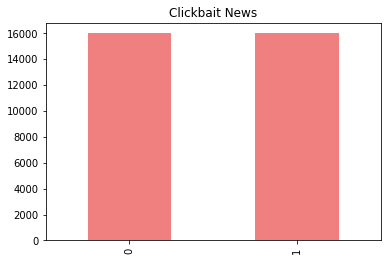

In [99]:
data.clickbait.value_counts().plot(kind = 'bar', title = 'Clickbait News', color = 'lightcoral' )

Apparently the distribution of data in both categories is balanced.

## The Feature: Headline

Understanding the feature might be difficult if only judge by the column values. I need a column to count the words (token) in each rows. 

### Word Count

In [100]:
data['word_count'] = data['headline'].apply(lambda x: len(str(x).split(" ")))
data

,headline,clickbait,word_count
0,Should I Get Bings,1,4
1,Which TV Female Friend Group Do You Belong In,1,9
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1,14
3,"This Vine Of New York On ""Celebrity Big Brothe...",1,12
4,A Couple Did A Stunning Photo Shoot With Their...,1,18
...,...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0,10
31996,"British Liberal Democrat Patsy Calton, 56, die...",0,9
31997,Drone smartphone app to help heart attack vict...,0,12
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0,9


Now, the word_count column shows us how many words are in one headline. Let's see how the descriptive statistics of this column will give us insight.

In [101]:
pd.DataFrame({
    'Clickbait': data[data.clickbait==1]['word_count'].describe(),
    'Normal': data[data.clickbait==0]['word_count'].describe()
})

,Clickbait,Normal
count,15999.000000,16001.000000
mean,9.942684,8.194988
std,2.660435,2.227746
min,1.000000,2.000000
25%,8.000000,7.000000
50%,10.000000,8.000000
75%,12.000000,9.000000
max,26.000000,21.000000


Clickbait headlines usually has more words in their headline than normal news. But there's also clickbait that has only one word in the headline. the range (Q3-Q1) in clickbait is wider than normal news, but the differentiate doesn't significant. This indicate to make headline clickbait there might be a tendencies of using more words than normal headline.

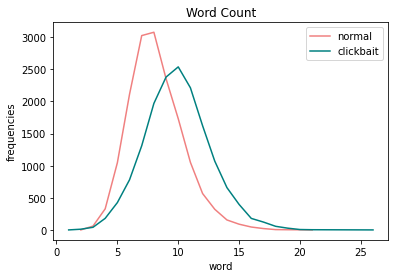

In [102]:
plt.title('Word Count')
data[data.clickbait==0]['word_count'].value_counts().sort_index().plot(color = 'lightcoral',label = 'normal')
data[data.clickbait==1]['word_count'].value_counts().sort_index().plot(color = 'teal',label = 'clickbait')
plt.xlabel('word')
plt.ylabel('frequencies')
plt.legend()

From the distribution of word usage, you might see from the clickbait graphic that the curve is wider in range 0-20 token, but the frequencies for the normal headline gathered in range 0-13 token. this give me insight that clickbait headlines usually has more words than normal headlines. 

### Stop Words

Stop Words are all tokens that has least information from a text dataset. For example, 'an', 'the', 'and', 'but', 'if', 'as', etc.
List of this stop words has been resumed in library `nltk` for english version. 

In [103]:
stop = stopwords.words("english")

All the stopwords has been listed in `stop` variable. Because the list token is in lower case, to detect stop words in each rows I change the headline into lower case first. 

In [104]:
data['headline_lower'] = data['headline'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
data

,headline,clickbait,word_count,headline_lower
0,Should I Get Bings,1,4,should i get bings
1,Which TV Female Friend Group Do You Belong In,1,9,which tv female friend group do you belong in
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1,14,"the new ""star wars: the force awakens"" trailer..."
3,"This Vine Of New York On ""Celebrity Big Brothe...",1,12,"this vine of new york on ""celebrity big brothe..."
4,A Couple Did A Stunning Photo Shoot With Their...,1,18,a couple did a stunning photo shoot with their...
...,...,...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0,10,"to make female hearts flutter in iraq, throw a..."
31996,"British Liberal Democrat Patsy Calton, 56, die...",0,9,"british liberal democrat patsy calton, 56, die..."
31997,Drone smartphone app to help heart attack vict...,0,12,drone smartphone app to help heart attack vict...
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0,9,"netanyahu urges pope benedict, in israel, to d..."


Now, the lower case headline is displayed in new column. Next, I will create new column for counting the stop words in each rows.

In [105]:
data['stopwords'] = data['headline_lower'].apply(lambda x: len([x for x in x.split() if x in stop]))
data[['headline_lower','stopwords']].head()

,headline_lower,stopwords
0,should i get bings,2
1,which tv female friend group do you belong in,4
2,"the new ""star wars: the force awakens"" trailer...",6
3,"this vine of new york on ""celebrity big brothe...",4
4,a couple did a stunning photo shoot with their...,9


In [106]:
x = data.headline_lower[0]
[x for x in x.split() if x in stop]

['should', 'i']

In the first text, `should i get bings` has 2 stopwords which are `should` and `i`. Now, let's visualize the distribution of stop words for each categories.

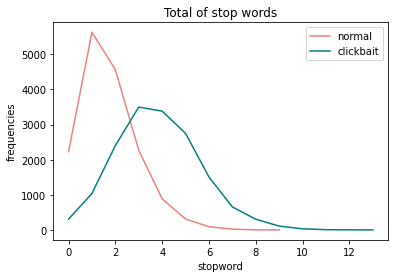

In [107]:
plt.title('Total of stop words')
data[data.clickbait==0]['stopwords'].value_counts().sort_index().plot(color = 'lightcoral',label = 'normal')
data[data.clickbait==1]['stopwords'].value_counts().sort_index().plot(color = 'teal',label = 'clickbait')
plt.xlabel('stopword')
plt.ylabel('frequencies')
plt.legend()

the curve of clickbait news is lower and spread in range 0-7 stop words. Normal news curve has higher curve gathered in range 0-4 stopwords. This means Clickbait news has more stop words in their headline more than normal news. This give me insight that if I reduce the stopwords in all corpus, the characteristics of clickbait news will be gone. Clickbait can be indicate with the usage of stop words and if I reduce it, the accuracy to predict clickbait news will be reduced as well.

### Punctuation

Next, I want to know the usage of punctuation in the dataset. As usual, I will create new column to count how many punctuation for each rows.

In [109]:
data['punct'] = data['headline'].apply(lambda x: sum([1 for char in x if char in string.punctuation]))
data

,headline,clickbait,word_count,headline_lower,stopwords,punct
0,Should I Get Bings,1,4,should i get bings,2,0
1,Which TV Female Friend Group Do You Belong In,1,9,which tv female friend group do you belong in,4,0
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1,14,"the new ""star wars: the force awakens"" trailer...",6,3
3,"This Vine Of New York On ""Celebrity Big Brothe...",1,12,"this vine of new york on ""celebrity big brothe...",4,2
4,A Couple Did A Stunning Photo Shoot With Their...,1,18,a couple did a stunning photo shoot with their...,9,0
...,...,...,...,...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0,10,"to make female hearts flutter in iraq, throw a...",3,1
31996,"British Liberal Democrat Patsy Calton, 56, die...",0,9,"british liberal democrat patsy calton, 56, die...",1,2
31997,Drone smartphone app to help heart attack vict...,0,12,drone smartphone app to help heart attack vict...,2,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0,9,"netanyahu urges pope benedict, in israel, to d...",2,2


The column has been added, now let's visualize the distribution

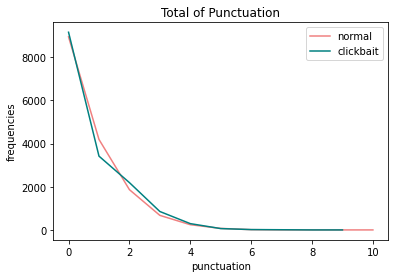

In [110]:
plt.title('Total of Punctuation')
data[data.clickbait==0]['punct'].value_counts().sort_index().plot(color = 'lightcoral',label = 'normal')
data[data.clickbait==1]['punct'].value_counts().sort_index().plot(color = 'teal',label = 'clickbait')
plt.xlabel('punctuation')
plt.ylabel('frequencies')
plt.legend()

both clickbait or normal news have the same distribution of punctuation, where usually they don't have many punctuation in their headlines. The maximum values for puntuation for a headline is 10 punctuation for normal news. The removal of the punctuation may not affect the accuracy of model prediction.

# Data Preprocessing

After understanding the dataset, I prepare the data to be put in the model. Because the model need number input, the feature need to be changed into a form that model can understand.

## Feature Selection

In EDA section, I have detect punctuation and stopwords. In this section, the punctuation will be reduced and the stopwords will not be handle to keep the origin of clickbait characteristic.

In [111]:
punctuation = lambda x: x.translate(str.maketrans('','',string.punctuation))

In [112]:
df['headline'] = df['headline'].apply(punctuation)
df.head()

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,The New Star Wars The Force Awakens Trailer Is...,1
3,This Vine Of New York On Celebrity Big Brother...,1
4,A Couple Did A Stunning Photo Shoot With Their...,1


above is the dataset that has been cleaned from unimportant punctuation.

## Split Dataset

Next will be splitting the dataset into train-validation-test set.

In [113]:
X_df, X_test, y_df, y_test = train_test_split(df.headline,df.clickbait,test_size=0.2,random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_df,y_df, test_size=0.2,random_state=1)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(20480,)
(5120,)
(6400,)
(20480,)
(5120,)
(6400,)


In [132]:
print('Total Token in train set: ',sum([len(i.split()) for i in X_train]))

Total Token in train set:  185111


In train set total token is 185111. This will affect for the determination of length of maximum vocab that I will use for the hyperparameter in vectorization section.

## Vectorization 

Vectorization is transformed the document into the vector based on list number of vocabularies that has been adapted from train set.

In [338]:
max_vocab_length = 5000
max_length = 14

text_vectorization = TextVectorization(max_tokens=max_vocab_length,
                                       standardize = 'lower_and_strip_punctuation',
                                       split = 'whitespace',
                                       ngrams = None,
                                       output_mode = 'int',
                                       output_sequence_length = max_length)

I chose `5000` length of vocabularies first and maximum length for each vector based on judgement from EDA in wordcount section. The maximum value for word count is 26 so I chose between 0-26 number and the `14` is able to try. The standardize would be `lower and strip punctuation` for data preprocessing. The split method is based on `whitespace`. Output mode is integer because I input the output sequence length with integer define as `max_length `.

In [339]:
text_vectorization.adapt(X_train)

after adapting from train set condition, let's try to vectorize a document to check if it works.

In [340]:
text_vectorization(df.headline[0])

<tf.Tensor: shape=(14,), dtype=int64, numpy=
array([43, 94, 79,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int64)>

the text has been transformed into a vector.

## Pipeline Tensorflow

Recurrent Neural Network might have spend time when training the dataset. One of the solution is to make a tensorflow pipeline that slice train set and shuffle them in batch size. this hopefully will cut a time in training process.

In [341]:
train_dataset = Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)
val_dataset = Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.shuffle(buffer_size=1024).batch(64)
test_dataset = Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(64)

## Embedding

Embedding prepared the data to be put in the model. This transform vector into tensor matrix that machine able to understand.

In [342]:
embedding = Embedding(input_dim = max_vocab_length,
                      output_dim = 128,
                      embeddings_initializer = 'uniform',
                      input_length = max_length
                     )

In [366]:
teks = text_vectorization(df.headline[0])
teks = embedding(teks)
teks

<tf.Tensor: shape=(14, 128), dtype=float32, numpy=
array([[ 0.39881876,  0.26563817, -0.28657275, ...,  0.35994598,
         0.33299732, -0.28333762],
       [ 0.17910881,  0.12318517, -0.17771342, ...,  0.22421107,
         0.10389429, -0.04920784],
       [ 0.17073631,  0.11360675, -0.08234769, ...,  0.18352345,
         0.18416063, -0.06234671],
       ...,
       [-0.06930971, -0.05142969,  0.07838079, ..., -0.06941971,
         0.04661696,  0.0106842 ],
       [-0.06930971, -0.05142969,  0.07838079, ..., -0.06941971,
         0.04661696,  0.0106842 ],
       [-0.06930971, -0.05142969,  0.07838079, ..., -0.06941971,
         0.04661696,  0.0106842 ]], dtype=float32)>

Vector from `text_vectorization` has been transformed to tensor matrix. This tensor will be fed into the model NN.

# Model Definition

I will choose neural network model addition with global average pooling layer as baseline model. The architecture of the model will be
1. Input layer which dtype is string cause dataset is in string form
2. Text Vectorization layer
3. Embedding layer
4. Global Average Pooling 1D layer
5. output layer with hyperparameter for activation function is sigmoid because the target is two class categories

In the model compile the hyperparameter is binary crossentropy because of binary categories target. The optimizer will be adam since it has an adaptive learning rate and fast converges, the metrics will be accuracy.


In [343]:
inputs = Input(shape=(1,),dtype = 'string') 
x = text_vectorization(inputs)  
x = embedding(x)
x = GlobalAveragePooling1D()(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model_nn = Model(inputs, outputs, name = 'nn')

model_nn.compile(loss = 'binary_crossentropy',
                 optimizer = 'adam',
                 metrics = ['accuracy'])

# Model Training

In model training, model that has been defined and compiled will be trained with hyperparameters as described:
1. epochs = 20 
2. callbacks where monitor validation loss and has patience = 3. 
The callbacks use Early stopping when validation loss has converged and `patience = 3` means if loss has converged during 3 epoch it will stop training and shows the last result.

In [344]:
call1 = EarlyStopping(monitor = 'val_loss', patience = 3)

In [345]:
model_nn_hist = model_nn.fit(train_dataset,
                             epochs = 20,
                             validation_data = (val_dataset),
                             callbacks = call1)

Epoch 1/20
320/320 [==============================] - 5s 14ms/step - loss: 0.3809 - accuracy: 0.8766 - val_loss: 0.1702 - val_accuracy: 0.9586
Epoch 2/20
320/320 [==============================] - 4s 13ms/step - loss: 0.1226 - accuracy: 0.9647 - val_loss: 0.1000 - val_accuracy: 0.9699
Epoch 3/20
320/320 [==============================] - 4s 13ms/step - loss: 0.0784 - accuracy: 0.9770 - val_loss: 0.0803 - val_accuracy: 0.9723
Epoch 4/20
320/320 [==============================] - 4s 13ms/step - loss: 0.0585 - accuracy: 0.9827 - val_loss: 0.0720 - val_accuracy: 0.9752
Epoch 5/20
320/320 [==============================] - 4s 13ms/step - loss: 0.0461 - accuracy: 0.9864 - val_loss: 0.0682 - val_accuracy: 0.9746
Epoch 6/20
320/320 [==============================] - 4s 13ms/step - loss: 0.0375 - accuracy: 0.9885 - val_loss: 0.0667 - val_accuracy: 0.9748
Epoch 7/20
320/320 [==============================] - 4s 13ms/step - loss: 0.0310 - accuracy: 0.9914 - val_loss: 0.0664 - val_accuracy: 0.9752

From the 20 epochs, the best result has shown at 10th epoch with total time consumed is 43.3s. 

# Model Evaluation

To ease my work, I put history of evaluation per epoch in dataframe and visualize it in line graph.

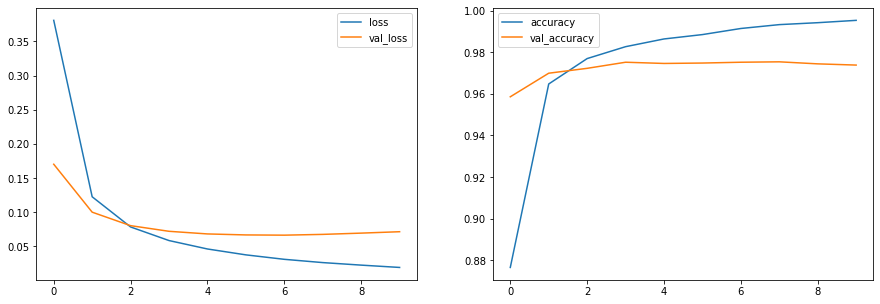

In [346]:
m1 = pd.DataFrame(model_nn_hist.history)
f,ax = plt.subplots(ncols  = 2, figsize = (15,5))
m1[['loss','val_loss']].plot(ax = ax[0])
m1[['accuracy','val_accuracy']].plot(ax = ax[1])
plt.show()

The gap between train and validation curve is wide enough so the performance of the model is overfitting. But the loss rate is low under 10% for validation and under 5% for train and the accuracy is high in 97% for validation. But the train accuracy convergent to 100%.

In [347]:
pred1_train = model_nn.predict(X_train)
pred1_train = np.where(pred1_train>0.5,1,0)
pred1_train

array([[1],
       [1],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [348]:
print(classification_report(y_train, pred1_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10238
           1       1.00      1.00      1.00     10242

    accuracy                           1.00     20480
   macro avg       1.00      1.00      1.00     20480
weighted avg       1.00      1.00      1.00     20480



The model train too well until get 100% right prediction.

In [349]:
pred1_val = model_nn.predict(X_val)
pred1_val = np.where(pred1_val>0.5,1,0)
print(classification_report(y_val,pred1_val))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2594
           1       0.98      0.97      0.97      2526

    accuracy                           0.97      5120
   macro avg       0.97      0.97      0.97      5120
weighted avg       0.97      0.97      0.97      5120



for validation prediction, the accuracy is 97% also for each class get 97% f1 score. From this case, I want to focus on `precision` score because it will be a problem if predict news (`Positive`) is not clickbait (`Negative`) but actually clickbait (`False Positive`) than predict clickbait but actually a normal news (`False Negative`). Because usually clickbait headline has negative connotations and lead opinion to one side only if reader just read the headline. It can drive public opinion into one side of story. Even worse when the clickbait headline news is received as a fact without checking what inside (which usually far from the headline tell you about) it will disappoint the reader and give bad ratings to the website. Thus, in this case, I want to minimize `False Positive` and get high `precision` in class 0.
from the evaluation of validation score, `precision` for class 0 is 97%.

Next, let's see how the performance of the model for new data (`X_test`)

In [350]:
pred1_test = model_nn.predict(X_test)
pred1_test = np.where(pred1_test>0.5,1,0)
print(classification_report(y_test,pred1_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3169
           1       0.98      0.97      0.98      3231

    accuracy                           0.98      6400
   macro avg       0.98      0.98      0.98      6400
weighted avg       0.98      0.98      0.98      6400



F1 score 98% for each metrics higher than the validation score. This mean the model is overfit or too powerful to predict this case because when train process the model is too good (even perfect). In testing process the accuracy decrease 2% from the training process, but in my perspective this gap is considered as a goodfit.

## Model LSTM

From Neural Network I get a good fit model so far, but how about the RNN model? hope we can find the best result in here.
RNN model that I use in this project is LSTM (Long Short-Term Memory) and GRU (Gated Reccurent Unit). Here's the baseline model for RNN model.

## Model Definition

In this model I use LSTM with 64 neuron, and all the hyperparameter in this model is still the same with NN model before.

In [351]:
inputs = Input(shape=(1,),dtype = 'string') 
x = text_vectorization(inputs)
x = embedding(x)
x = LSTM(64)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model_lstm = Model(inputs, outputs, name = 'lstm')

model_lstm.compile(loss = 'binary_crossentropy',
                 optimizer = 'adam',
                 metrics = ['accuracy'])

## Model Training

callbacks and the epochs have the same hyperparameters like the first model. 

In [352]:
model_lstm_hist = model_lstm.fit(train_dataset,
                             epochs = 20,
                             validation_data = (val_dataset),
                             callbacks = call1)

Epoch 1/20
320/320 [==============================] - 20s 26ms/step - loss: 0.0399 - accuracy: 0.9904 - val_loss: 0.0876 - val_accuracy: 0.9738
Epoch 2/20
320/320 [==============================] - 8s 26ms/step - loss: 0.0121 - accuracy: 0.9967 - val_loss: 0.0969 - val_accuracy: 0.9727
Epoch 3/20
320/320 [==============================] - 8s 26ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.1101 - val_accuracy: 0.9721
Epoch 4/20
320/320 [==============================] - 8s 26ms/step - loss: 0.0087 - accuracy: 0.9979 - val_loss: 0.1170 - val_accuracy: 0.9715


The convergent result has been shown up in 4th epoch. This train process spent 45.5s longer than NN model which spent 43.3s

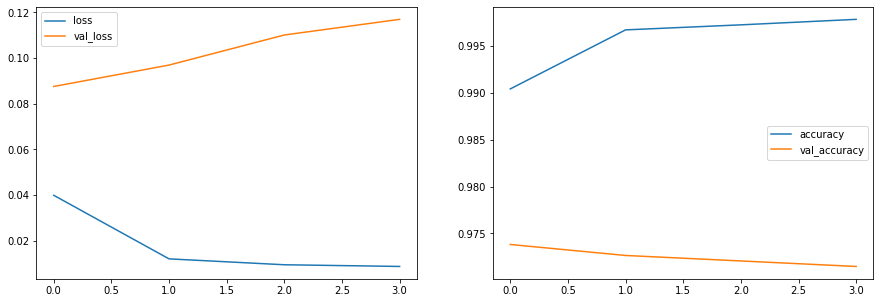

In [353]:
m2 = pd.DataFrame(model_lstm_hist.history)
f,ax = plt.subplots(ncols  = 2, figsize = (15,5))
m2[['loss','val_loss']].plot(ax = ax[0])
m2[['accuracy','val_accuracy']].plot(ax = ax[1])
plt.show()

The loss validation curve is not convergent, accuracy as well. Train loss converges to 0, train accuracy converges to 1. Gap between train-validation graphic is wider than NN model meaning the model is overfit.

In [354]:
pred2_train = model_lstm.predict(X_train)
pred2_val = model_lstm.predict(X_val)
pred2_test = model_lstm.predict(X_test)
pred2_train = np.where(pred2_train>0.5,1,0)
pred2_val = np.where(pred2_val>0.5,1,0)
pred2_test = np.where(pred2_test>0.5,1,0)

In [355]:
print('train: \n',classification_report(y_train,pred2_train))
print('val: \n',classification_report(y_val,pred2_val))
print('test: \n',classification_report(y_test,pred2_test))

train: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10238
           1       1.00      1.00      1.00     10242

    accuracy                           1.00     20480
   macro avg       1.00      1.00      1.00     20480
weighted avg       1.00      1.00      1.00     20480

val: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      2594
           1       0.97      0.97      0.97      2526

    accuracy                           0.97      5120
   macro avg       0.97      0.97      0.97      5120
weighted avg       0.97      0.97      0.97      5120

test: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      3169
           1       0.97      0.98      0.97      3231

    accuracy                           0.97      6400
   macro avg       0.97      0.97      0.97      6400
weighted avg       0.97      0.97      0.97      6

Recall score is higher than precision in 1 class for test set. The accuracy for both validation and test is 0.97. For comparation with NN model, there's improvement in epochs training but the total time spent dont improve even take more time to train LSTM model. I only need 5 epochs to train LSTM model when in NN model I need 10 epochs. But test score in LSTM model is lower 1% than NN model. NN model still a better choice if compared to LSTM model in this case.

## Model GRU

This is baseline model for GRU model. The hyperparameter for other layer is still the same. The neuron for GRU model is 64 neurons. I choose epochs 50 in case the process take more time to converge.

In [178]:
#Model Definitio
inputs = Input(shape=(1,),dtype = 'string') 
x = text_vectorization(inputs)
x = embedding(x)
x = GRU(64)(x) 
outputs = Dense(1, activation = 'sigmoid')(x)
model_gru = Model(inputs, outputs, name = 'gru')

model_gru.compile(loss = 'binary_crossentropy',
                 optimizer = 'adam',
                 metrics = ['accuracy'])
# Model Training
model_gru_hist = model_gru.fit(train_dataset,
                             epochs = 50,
                             validation_data = (val_dataset),
                             callbacks = call1
                             )

Epoch 1/50
320/320 [==============================] - 9s 24ms/step - loss: 0.0427 - accuracy: 0.9827 - val_loss: 0.1301 - val_accuracy: 0.9703
Epoch 2/50
320/320 [==============================] - 7s 22ms/step - loss: 0.0062 - accuracy: 0.9982 - val_loss: 0.1494 - val_accuracy: 0.9703
Epoch 3/50
320/320 [==============================] - 7s 22ms/step - loss: 0.0054 - accuracy: 0.9984 - val_loss: 0.1536 - val_accuracy: 0.9705
Epoch 4/50
320/320 [==============================] - 7s 21ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.1648 - val_accuracy: 0.9713


Only need 4 epochs to reach convergent score. The gap for loss train-validation is wide, around 0.16. Let's put all this number to a dataframe.

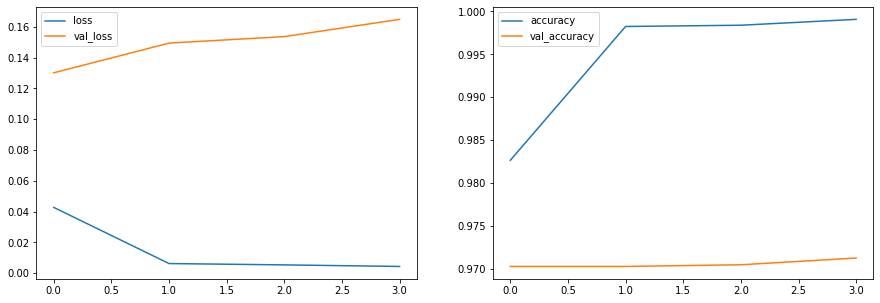

In [179]:
m3 = pd.DataFrame(model_gru_hist.history)
f,ax = plt.subplots(ncols  = 2, figsize = (15,5))
m3[['loss','val_loss']].plot(ax = ax[0])
m3[['accuracy','val_accuracy']].plot(ax = ax[1])
plt.show()

Despite of fast converges, the gap in train-validation is higher than before. Validation loss increase overtime, so is accuracy. Train loss and accuracy already converges in first epoch.

In [180]:
pred3_train = model_gru.predict(X_train)
pred3_val = model_gru.predict(X_val)
pred3_test = model_gru.predict(X_test)
pred3_train = np.where(pred3_train>0.5,1,0)
pred3_val = np.where(pred3_val>0.5,1,0)
pred3_test = np.where(pred3_test>0.5,1,0)

In [356]:
print('train: \n',classification_report(y_train,pred3_train))
print('val: \n',classification_report(y_val,pred3_val))
print('test: \n',classification_report(y_test,pred3_test))

train: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10238
           1       1.00      1.00      1.00     10242

    accuracy                           1.00     20480
   macro avg       1.00      1.00      1.00     20480
weighted avg       1.00      1.00      1.00     20480

val: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      2594
           1       0.97      0.98      0.97      2526

    accuracy                           0.97      5120
   macro avg       0.97      0.97      0.97      5120
weighted avg       0.97      0.97      0.97      5120

test: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      3169
           1       0.97      0.98      0.97      3231

    accuracy                           0.97      6400
   macro avg       0.97      0.97      0.97      6400
weighted avg       0.97      0.97      0.97      6

Precision score in 0 class for both validation and train get 98% score. This model get better result by judging from total time (30.5s) and precision in class 0 get 98% score. Next, I will improve the architecure of GRU baseline model to get better model performance.

# Model Improvement

## Improvement 1
In this improvement I will increase the neuron to 128 to see the comparation between baseline model and choose adamax optimizer. Adamax can be superior than adam optimizer when embedding layer is added to the architecture (Keras, 2022).

In [182]:
inputs = Input(shape=(1,),dtype = 'string') 
x = text_vectorization(inputs)
x = embedding(x)
x = GRU(128)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model_gru2 = Model(inputs, outputs, name = 'gru2')

model_gru2.compile(loss = 'binary_crossentropy',
                 optimizer = 'adamax',
                 metrics = ['accuracy'])

model_gru2_hist = model_gru2.fit(train_dataset,
                             epochs = 50,
                             validation_data = (val_dataset),
                             callbacks = call1
                             )

Epoch 1/50
320/320 [==============================] - 11s 29ms/step - loss: 0.0315 - accuracy: 0.9883 - val_loss: 0.1181 - val_accuracy: 0.9713
Epoch 2/50
320/320 [==============================] - 9s 27ms/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 0.1325 - val_accuracy: 0.9686
Epoch 3/50
320/320 [==============================] - 11s 35ms/step - loss: 0.0034 - accuracy: 0.9993 - val_loss: 0.1478 - val_accuracy: 0.9701
Epoch 4/50
320/320 [==============================] - 9s 29ms/step - loss: 0.0029 - accuracy: 0.9994 - val_loss: 0.1670 - val_accuracy: 0.9668


Total time to train this model is 41.1s higher than baseline model. Let's see how the performance of the model

### Model Evaluation

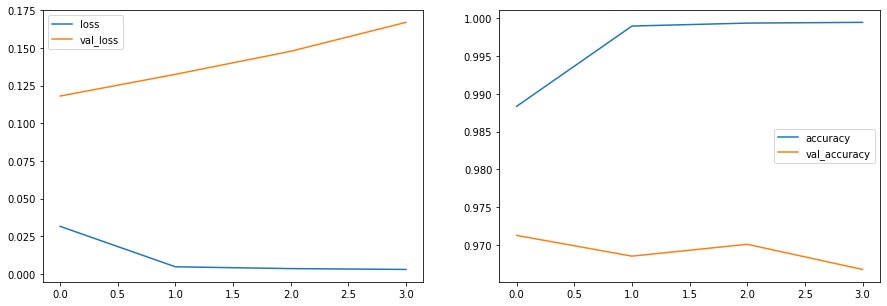

In [187]:
m4 = pd.DataFrame(model_gru2_hist.history)
f,ax = plt.subplots(ncols  = 2, figsize = (15,5))
m4[['loss','val_loss']].plot(ax = ax[0])
m4[['accuracy','val_accuracy']].plot(ax = ax[1])
plt.show()

Seems like the model is overfit becasue the validation curve increasing overtime when train curve decrease.

In [183]:
pred4_train = model_gru2.predict(X_train)
pred4_val = model_gru2.predict(X_val)
pred4_test = model_gru2.predict(X_test)
pred4_train = np.where(pred4_train>0.5,1,0)
pred4_val = np.where(pred4_val>0.5,1,0)
pred4_test = np.where(pred4_test>0.5,1,0)

In [357]:
print('train: \n',classification_report(y_train,pred4_train))
print('val: \n',classification_report(y_val,pred4_val))
print('test: \n',classification_report(y_test,pred4_test))

train: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10238
           1       1.00      1.00      1.00     10242

    accuracy                           1.00     20480
   macro avg       1.00      1.00      1.00     20480
weighted avg       1.00      1.00      1.00     20480

val: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      2594
           1       0.97      0.97      0.97      2526

    accuracy                           0.97      5120
   macro avg       0.97      0.97      0.97      5120
weighted avg       0.97      0.97      0.97      5120

test: 
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      3169
           1       0.97      0.97      0.97      3231

    accuracy                           0.97      6400
   macro avg       0.97      0.97      0.97      6400
weighted avg       0.97      0.97      0.97      6

The classification report shows that precision for 0 class is decrease 1% and other metrics remain the same. Model improvement 1 dont have improved performance if compare to baseline model.

## Improvement 2
I improve the neuron in this GRU model to 8 neuron only and other hyperparameters is the same.

In [186]:
#Model Definition
inputs = Input(shape=(1,),dtype = 'string') 
x = text_vectorization(inputs)
x = embedding(x)
x = GRU(8)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model_gru3 = Model(inputs, outputs, name = 'gru3')

model_gru3.compile(loss = 'binary_crossentropy',
                 optimizer = 'adamax',
                 metrics = ['accuracy'])
# Model Training
model_gru3_hist = model_gru3.fit(train_dataset,
                             epochs = 50,
                             validation_data = (val_dataset),
                             callbacks = call1
                             )

Epoch 1/50
320/320 [==============================] - 11s 26ms/step - loss: 0.4149 - accuracy: 0.8447 - val_loss: 0.1814 - val_accuracy: 0.9506
Epoch 2/50
320/320 [==============================] - 6s 20ms/step - loss: 0.0697 - accuracy: 0.9887 - val_loss: 0.0856 - val_accuracy: 0.9750
Epoch 3/50
320/320 [==============================] - 7s 23ms/step - loss: 0.0221 - accuracy: 0.9973 - val_loss: 0.0933 - val_accuracy: 0.9717
Epoch 4/50
320/320 [==============================] - 7s 23ms/step - loss: 0.0133 - accuracy: 0.9983 - val_loss: 0.1024 - val_accuracy: 0.9703
Epoch 5/50
320/320 [==============================] - 7s 23ms/step - loss: 0.0094 - accuracy: 0.9988 - val_loss: 0.1106 - val_accuracy: 0.9699


Total time consumed is 40.8s, longer than improvement 1 but faster than baseline model of GRU

### Model Evaluation

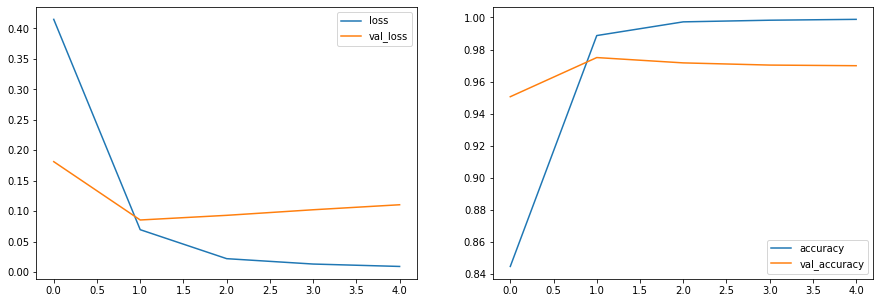

In [188]:
m5 = pd.DataFrame(model_gru3_hist.history)
f,ax = plt.subplots(ncols  = 2, figsize = (15,5))
m5[['loss','val_loss']].plot(ax = ax[0])
m5[['accuracy','val_accuracy']].plot(ax = ax[1])
plt.show()

From graphic above, this model is less overfit than improvement 1 and GRU baseline model.

In [189]:
pred5_train = model_gru2.predict(X_train)
pred5_val = model_gru2.predict(X_val)
pred5_test = model_gru2.predict(X_test)
pred5_train = np.where(pred5_train>0.5,1,0)
pred5_val = np.where(pred5_val>0.5,1,0)
pred5_test = np.where(pred5_test>0.5,1,0)

In [190]:
print('train: \n',classification_report(y_train,pred5_train))
print('test: \n',classification_report(y_test,pred5_test))
print('val: \n',classification_report(y_val,pred5_val))

train: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     10238
           1       1.00      1.00      1.00     10242

    accuracy                           1.00     20480
   macro avg       1.00      1.00      1.00     20480
weighted avg       1.00      1.00      1.00     20480

test: 
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      3169
           1       0.98      0.97      0.97      3231

    accuracy                           0.97      6400
   macro avg       0.97      0.97      0.97      6400
weighted avg       0.97      0.97      0.97      6400

val: 
               precision    recall  f1-score   support

           0       0.96      0.97      0.97      2594
           1       0.97      0.96      0.97      2526

    accuracy                           0.97      5120
   macro avg       0.97      0.97      0.97      5120
weighted avg       0.97      0.97      0.97      5

Precision score for validation is decrease to 96% and recall is higher than precision. This model improves in time and less overfit. Maybe I can reduce the neuron more.

# Improvement 3
The improvement from this architecture will be 
1. reduce neuron to 4 neuron
2. add recurrent_dropout = 0.2 in GRU layer
3. add dropout layer that the dropout rate is 0.4

In [313]:
# Model Definition
inputs = Input(shape=(1,),dtype = 'string') 
x = text_vectorization(inputs)
x = embedding(x)
x = GRU(4,recurrent_dropout=0.2)(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model_gru4 = Model(inputs, outputs, name = 'gru4')

model_gru4.compile(loss = 'binary_crossentropy',
                 optimizer = 'adamax',
                 metrics = ['accuracy'])
# Model Training
model_gru4_hist = model_gru4.fit(train_dataset,
                             epochs = 50,
                             validation_data = (val_dataset),
                             callbacks = call1
                             )

Epoch 1/50
320/320 [==============================] - 5s 11ms/step - loss: 0.6570 - accuracy: 0.6216 - val_loss: 0.5204 - val_accuracy: 0.8350
Epoch 2/50
320/320 [==============================] - 3s 11ms/step - loss: 0.3321 - accuracy: 0.8942 - val_loss: 0.1779 - val_accuracy: 0.9420
Epoch 3/50
320/320 [==============================] - 3s 10ms/step - loss: 0.1946 - accuracy: 0.9415 - val_loss: 0.1252 - val_accuracy: 0.9580
Epoch 4/50
320/320 [==============================] - 3s 10ms/step - loss: 0.1510 - accuracy: 0.9526 - val_loss: 0.1089 - val_accuracy: 0.9635
Epoch 5/50
320/320 [==============================] - 3s 9ms/step - loss: 0.1272 - accuracy: 0.9620 - val_loss: 0.1012 - val_accuracy: 0.9646
Epoch 6/50
320/320 [==============================] - 3s 9ms/step - loss: 0.1162 - accuracy: 0.9642 - val_loss: 0.0945 - val_accuracy: 0.9672
Epoch 7/50
320/320 [==============================] - 3s 9ms/step - loss: 0.1045 - accuracy: 0.9675 - val_loss: 0.0924 - val_accuracy: 0.9680
Ep

this model takes 44.4s to converge longer than any other GRU model but still faster than NN model. This model takes more epochs as well.

### Model Evaluation

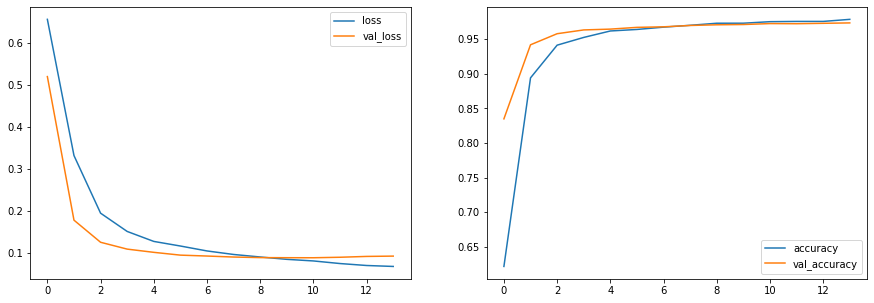

In [314]:
m6 = pd.DataFrame(model_gru4_hist.history)
f,ax = plt.subplots(ncols  = 2, figsize = (15,5))
m6[['loss','val_loss']].plot(ax = ax[0])
m6[['accuracy','val_accuracy']].plot(ax = ax[1])
plt.show()

The performance of the model is converge simultaneously. So far, this is the best fit performance I have. Let's check the precision and accuracy score

In [315]:
pred6_train = model_gru4.predict(X_train)
pred6_val = model_gru4.predict(X_val)
pred6_test = model_gru4.predict(X_test)
pred6_train = np.where(pred6_train>0.5,1,0)
pred6_val = np.where(pred6_val>0.5,1,0)
pred6_test = np.where(pred6_test>0.5,1,0)

In [316]:
print('train: \n',classification_report(y_train,pred6_train))
print('test: \n',classification_report(y_test,pred6_test))
print('val: \n',classification_report(y_val,pred6_val))

train: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     10238
           1       0.99      1.00      0.99     10242

    accuracy                           0.99     20480
   macro avg       0.99      0.99      0.99     20480
weighted avg       0.99      0.99      0.99     20480

test: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      3169
           1       0.97      0.98      0.97      3231

    accuracy                           0.97      6400
   macro avg       0.97      0.97      0.97      6400
weighted avg       0.97      0.97      0.97      6400

val: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      2594
           1       0.97      0.98      0.97      2526

    accuracy                           0.97      5120
   macro avg       0.97      0.97      0.97      5120
weighted avg       0.97      0.97      0.97      5

Precision get 98% score and recall is lower than precision. The improvement that this model have is converges fast and have high precision. This architecture get the best result so far. But I still want to do improvement in dropout number.

# Improvement 4
In this improvement I will increase the recurrent dropout to 0.3.

In [324]:
# Model Definition
inputs = Input(shape=(1,),dtype = 'string') 
x = text_vectorization(inputs)
x = embedding(x)
x = GRU(4,recurrent_dropout=0.3)(x)
x = Dropout(0.4)(x)
outputs = Dense(1, activation = 'sigmoid')(x)
model_gru5 = Model(inputs, outputs, name = 'gru5')

model_gru5.compile(loss = 'binary_crossentropy',
                 optimizer = 'adamax',
                 metrics = ['accuracy'])
# Model training
model_gru5_hist = model_gru5.fit(train_dataset,
                             epochs = 50,
                             validation_data = (val_dataset),
                             callbacks = call1
                             )

Epoch 1/50
320/320 [==============================] - 6s 12ms/step - loss: 0.6156 - accuracy: 0.6995 - val_loss: 0.4427 - val_accuracy: 0.9342
Epoch 2/50
320/320 [==============================] - 3s 9ms/step - loss: 0.2992 - accuracy: 0.9447 - val_loss: 0.1597 - val_accuracy: 0.9645
Epoch 3/50
320/320 [==============================] - 3s 9ms/step - loss: 0.1565 - accuracy: 0.9639 - val_loss: 0.1028 - val_accuracy: 0.9688
Epoch 4/50
320/320 [==============================] - 3s 9ms/step - loss: 0.1144 - accuracy: 0.9708 - val_loss: 0.0885 - val_accuracy: 0.9719
Epoch 5/50
320/320 [==============================] - 3s 9ms/step - loss: 0.0963 - accuracy: 0.9737 - val_loss: 0.0857 - val_accuracy: 0.9734
Epoch 6/50
320/320 [==============================] - 3s 10ms/step - loss: 0.0844 - accuracy: 0.9756 - val_loss: 0.0861 - val_accuracy: 0.9734
Epoch 7/50
320/320 [==============================] - 3s 9ms/step - loss: 0.0794 - accuracy: 0.9767 - val_loss: 0.0868 - val_accuracy: 0.9746
Epoc

Training process has stop in 8 epoch with total time is 26.6s which is the fastest training time so far.

### Model Evaluation

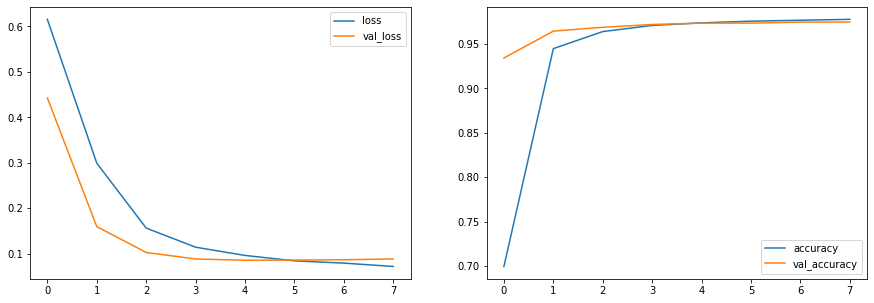

In [325]:
m7 = pd.DataFrame(model_gru5_hist.history)
f,ax = plt.subplots(ncols  = 2, figsize = (15,5))
m7[['loss','val_loss']].plot(ax = ax[0])
m7[['accuracy','val_accuracy']].plot(ax = ax[1])
plt.show()

this model has converges and get the best fit in 8 epoch. 

In [326]:
pred7_train = model_gru5.predict(X_train)
pred7_val = model_gru5.predict(X_val)
pred7_test = model_gru5.predict(X_test)
pred7_train = np.where(pred7_train>0.5,1,0)
pred7_val = np.where(pred7_val>0.5,1,0)
pred7_test = np.where(pred7_test>0.5,1,0)

In [327]:
print('train: \n',classification_report(y_train,pred7_train))
print('test: \n',classification_report(y_test,pred7_test))
print('val: \n',classification_report(y_val,pred7_val))

train: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     10238
           1       0.99      0.99      0.99     10242

    accuracy                           0.99     20480
   macro avg       0.99      0.99      0.99     20480
weighted avg       0.99      0.99      0.99     20480

test: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      3169
           1       0.97      0.98      0.97      3231

    accuracy                           0.97      6400
   macro avg       0.97      0.97      0.97      6400
weighted avg       0.97      0.97      0.97      6400

val: 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      2594
           1       0.97      0.98      0.97      2526

    accuracy                           0.97      5120
   macro avg       0.97      0.97      0.97      5120
weighted avg       0.97      0.97      0.97      5

precision score is higher than recall. Although the scores is not different significantly but this is the best model for GRU where the total time to train is the fastest, the accuracy is 97%, and has the best fit performance. Thus, this model is the best architecure among any other neural network models.

# Model Saving

After obtain the best architecture, I will save best model so I can use it again. I will use this model to make an app that can detect clickbait news.

I save the last improvement of GRU model and name it with model_best.tf

In [374]:
model_gru5.save('model_best.tf')

INFO:tensorflow:Assets written to: model_best.tf\assets


INFO:tensorflow:Assets written to: model_best.tf\assets


After that to check if the model has been successfully save, I load the model and define it in `model` variable.

In [375]:
model = load_model('model_best.tf')

In [376]:
model.summary()

Model: "gru5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 14)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 14, 128)           640000    
                                                                 
 gru_22 (GRU)                (None, 4)                 1608      
                                                                 
 dropout_13 (Dropout)        (None, 4)                 0         
                                                                 
 dense_33 (Dense)            (None, 1)                 5         
                                                              

In [385]:
model_gru5.summary()

Model: "gru5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_37 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 14)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 14, 128)           640000    
                                                                 
 gru_22 (GRU)                (None, 4)                 1608      
                                                                 
 dropout_13 (Dropout)        (None, 4)                 0         
                                                                 
 dense_33 (Dense)            (None, 1)                 5         
                                                              

the summary of saved model and best improvement GRU model is the same so I already saved the rigth best model.

# Model Inference

In this section, I predict new data that is not from the dataset with saved model.

In [220]:
new = [
    'A girl playing with snow until night without freezing'
]
new1= [
    'Timor-Leste presidential election: José Ramos-Horta wins in landslide'
]


the first inference is clickbait news that I made and `new1` is normal news from [The Guardian](https://www.theguardian.com/world/2022/apr/21/timor-leste-presidential-election-jose-ramos-horta-wins-in-landslide)


In [378]:
p = model.predict(new)
p = np.where(p>0.5,1,0)
p

array([[1]])

model predict first news as clickbait which is true.

In [379]:
p2 = model.predict(new1)
p2 = np.where(p2>0.5,1,0)
p2

array([[0]])

Model predict news from The Guardian as normal news which is correct. Let's try inference set in a few headlines.

In [380]:
new2 = [
        "This Weird Trick Increased the Conversion Rate of our Landing Page in 110%",
        'Zelensky says Blinken and Austin will visit Ukraine on Sunday',
        "Today's news in 10 minutes"
]

first news is clickbait, second news is news from [CNN](https://edition.cnn.com/2022/04/23/politics/blinken-austin-zelensky-ukraine-visit/index.html), third news is from [CNN](https://edition.cnn.com/2022/04/25/cnn10/ten-content-tues/index.html) too 

In [381]:
p3 = model.predict(new2)
p3 = np.where(p3>0.5,1,0)
p3

array([[1],
       [0],
       [1]])

The model predict the third news incorrectly. But as I explained before, predict clickbait that actually not clickbait is not as dangerous as predict normal news as clickbait. Even, this can give feedback to news author to make safer headline news so that the headline is not classified as clickbait news.

In [382]:
new3 = 'Clickbait: The changing face of online journalism'
p4 = model.predict([new3])
p4 = np.where(p4>0.5,1,0)
p4

array([[0]])

I tried the other form of inference data where the input is not a list but just a string. To process this form, the data still need to be in a list form. So the list can be put in predict function like this  `predict([...])`. this headline news is from [BBC](https://www.bbc.com/news/uk-wales-34213693).
The model predict correctly as a normal news.

# Conclusion

## EDA Analysis

The dataset I have has two column which is Headline (as feature) and Clickbait (as target). Clickbait news define as 1 and not clickbait as 0. there's 32000 text headlines that have been labelled. Exploration of the data get some insights:
- Proportions of clickbait and normal news is balanced
- Clickbait headlines usually has more words in their headline than normal news
- Clickbait news has more stop words in their headline more than normal news
- Both clickbait and normal news have the same distribution of punctuation, where usually they don't have many punctuation in their headlines

After understanding the dataset, I know that if I remove stop words from corpus then the characteristics of clickbait news will be reduced. Therefore, in data pre-processing I didn't remove the stopwords. To pre-process the dataset I do several steps:
1. Remove punctuations
2. Split Dataset
3. Vectorization
3. Pipeline tensorflow
4. Embedding


## Model Analysis
Baseline model in this project is 
1. Deep Neural Network with pooling layer (accuracy: 97%, precision: 97%, time: 43.3s, performance: overfit)
2. Recurrent Neural Network: LSTM (accuracy: 97%, precision 97%, time: 45.5s, performance: overfit)
3. Recurrent Neural network: GRU (accuracy: 97%, precision 98%, time: 30.5s, performance: overfit)

Since the GRU model has fastest training time I decided to do improvements in GRU model. the comparation of improvement model is shown below:

| model | Improvement   | accuracy  | precision |  time | performance|
| ----- | --------------|-----------|-----------| ----- | -----------|
| GRU 2  | 128 neuron, adamax| 97% | 97% | 41.1| overfit|
| GRU 3 | 8 neuron  | 97% | 96%| 40.8| overfit|
| GRU 4 | 4 neuron, 0.2 reccurrent dropout, dropout layer 0.4| 97% | 98%| 44.4| good fit|
| GRU 5 | 4 neuron, 0.3 reccurrent dropout, dropout layer 0.4| 97% | 98%| 26.6| good fit|

the best architecture is GRU 5 because of this model train faster than other and the performance is good fit.

# References
1. CNN. 2022. *Today's news in 10 minutes*. [link](https://edition.cnn.com/2022/04/25/cnn10/ten-content-tues/index.html)
2. France-Presse, A. 2022. *Timor-Leste presidential election: José Ramos-Horta wins in landslide*. The Guardian [link](https://www.theguardian.com/world/2022/apr/21/timor-leste-presidential-election-jose-ramos-horta-wins-in-landslide)
3. Keras. 2022. *Adamax*. [link](https://keras.io/api/optimizers/adamax/)
4. Tawfeeq et al. 2022. *Zelensky says Blinken and Austin will visit Ukraine on Sunday*. CNN. [link](https://edition.cnn.com/2022/04/23/politics/blinken-austin-zelensky-ukraine-visit/index.html)

| Model | Hyperparameter   | Accuracy  | Precision |  Time | Performance|
| ----- | --------------|-----------|-----------| ----- | -----------|
| DNN  | 64 neuron, global pooling layer| 97% | 97% | 43.3s| overfit|
| LSTM | 64 neuron  | 97% | 97%| 45.5s| overfit|
| GRU | 64 neuron| 97% | 98%| 30.5s| overfit|
